In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from keras.optimizers import Adam
import skimage as skimage
import os
from glob import glob
import h5py

ModuleNotFoundError: No module named 'skimage'

In [5]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

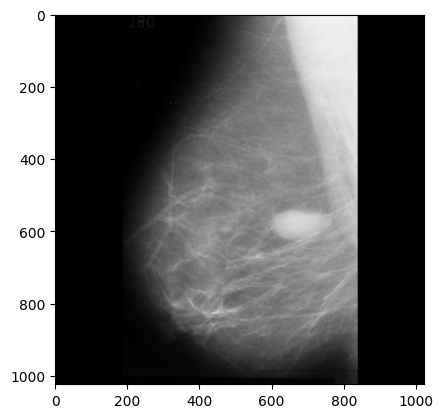

In [8]:
def display_pgm_image(file_path):
    img = mpimg.imread(file_path)
    plt.imshow(img, cmap='gray')
    plt.show()

# Replace 'your_image.pgm' with the actual path to your PGM image file
pgm_path = './data/all-mias/mdb025.pgm'
display_pgm_image(pgm_path)

In [3]:
base_h5 = os.path.join('/kaggle/input/mias-mammography/all_mias_scans.h5')
tif_dir = 'tiffs'
os.makedirs(tif_dir, exist_ok=True)
with h5py.File(base_h5, 'r') as f:
    mammo_df = pd.DataFrame(
        {k: v[()] if len(v.shape)==1 else [sub_v[()] for sub_v in v] 
         for k,v in f.items()}
    )
for k in mammo_df.columns:
    if isinstance(mammo_df[k].values[0], bytes):
        mammo_df[k] = mammo_df[k].map(lambda x: x.decode())
# save data to disk
from skimage.io import imsave
def to_path(c_row):
    out_path = os.path.join(tif_dir, '%s.tif' % c_row['REFNUM'])
    imsave(out_path, c_row['scan'])
    return out_path
mammo_df['scan'] = mammo_df.apply(to_path,1)
mammo_df.sample(20)

NameError: name 'os' is not defined

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

class_enc = LabelEncoder()
mammo_df['CLASS_ID'] = class_enc.fit_transform(mammo_df['CLASS'])
mammo_df['CLASS_VEC'] = mammo_df['CLASS_ID'].map(lambda x: to_categorical(x, 
                                                                          num_classes=len(class_enc.classes_)))
mammo_df[['CLASS_ID', 'RADIUS', 'SEVERITY']].hist(figsize = (10, 5))

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from sklearn.model_selection import train_test_split
raw_train_df, valid_df = train_test_split(mammo_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = mammo_df[['CLASS_ID', 'SEVERITY']])
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])
raw_train_df.sample(1)

In [ ]:
train_df = raw_train_df.groupby(['CLASS', 'SEVERITY']).apply(lambda x: x.sample(100, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])
train_df[['CLASS_ID', 'RADIUS']].hist(figsize = (10, 5))

In [ ]:
print("tiffs length:     ", len(os.listdir("/kaggle/working/tiffs")))
print("classes:          ", class_enc.classes_) 
print("dataframe_length: ", len(mammo_df))

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

# Assuming 'tiffs' is the directory containing your TIFF images
source_directory = 'tiffs'

# Create the main directory
main_directory = 'main_directory'
os.makedirs(main_directory, exist_ok=True)

# Create subdirectories for train and test
train_directory = os.path.join(main_directory, 'train')
test_directory = os.path.join(main_directory, 'test')
os.makedirs(train_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

# Split the data into train and test
train_df, test_df = train_test_split(mammo_df, test_size=0.2, random_state=42, stratify=mammo_df['CLASS'])

# Function to copy images to the appropriate directory and convert to PNG
def copy_and_convert_images(df, destination_directory):
    for index, row in df.iterrows():
        class_name = row['CLASS']
        image_path = row['scan']
        class_directory = os.path.join(destination_directory, class_name)
        os.makedirs(class_directory, exist_ok=True)

        # Open the TIFF image
        with Image.open(image_path) as img:
            # Construct the path for the converted image (replace .tif with .png)
            converted_path = os.path.join(class_directory, os.path.splitext(os.path.basename(image_path))[0] + '.png')

            # Save the image in PNG format
            img.save(converted_path, 'PNG')

# Copy and convert images to train and test directory
copy_and_convert_images(train_df, train_directory)
copy_and_convert_images(test_df, test_directory)

print("Conversion and copy complete.")

In [ ]:
train_dir = "/kaggle/working/main_directory/train"
val_dir = "/kaggle/working/main_directory/test"

image_size = (244, 244)
batch_size = 16
# ['ARCH','ASYM','CALC','CIRC','MISC','NORM','SPIC']

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            color_mode = 'rgb',
                                                            labels = 'inferred',
                                                            batch_size = 32,
                                                            label_mode = 'int',
                                                            image_size = image_size,
                                                            seed = 42,
                                                            shuffle = True)

val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                          color_mode = 'rgb',
                                                          batch_size = 32,
                                                          labels = 'inferred',
                                                          label_mode = 'int',
                                                          image_size = image_size)

class_names = train_dataset.class_names
print("class names: ", train_dataset.class_names)
for images, labels in train_dataset.take(1):
    print("Example images shape:", images.shape)
    print("Example labels:", labels.numpy())

for images, labels in val_dataset.take(20):
    print("Example images shape:", images.shape)
    print("Example labels:", labels.numpy())

In [ ]:
train_dataset.take(1)

import matplotlib.pyplot as plt

# Take one batch with a batch size of 1
for images, labels in train_dataset.take(1):
    # Assuming your batch size is 1, so there's only one image in the batch
    image = images[0]
    label = labels[0].numpy()  # Convert to numpy array if needed
    max_value = tf.reduce_max(image)
    min_value = tf.reduce_min(image)

    # Print or use the values as needed
    print("Maximum value:", max_value.numpy())
    print("Minimum value:", min_value.numpy())

for images, labels in val_dataset.take(1):
    # Assuming your batch size is 1, so there's only one image in the batch
    image = images[0]
    label = labels[0].numpy()  # Convert to numpy array if needed
    max_value = tf.reduce_max(image)
    min_value = tf.reduce_min(image)

    # Print or use the values as needed
    print("Maximum value:", max_value.numpy())
    print("Minimum value:", min_value.numpy())
    print("image shape:", image.shape)
    print("image dtype:", image.dtype)

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.15),
  layers.RandomZoom(0.15),
  layers.RandomHeight(0.15),
  layers.RandomWidth(0.15),
  layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

In [ ]:
inputs = layers.Input(shape = (244, 244, 3), dtype = tf.float64)
x = data_augmentation(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, 2, activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(32, 2, activation = 'relu', padding = 'same')(x)
x = layers.MaxPool2D(2)(x)
x = layers.Dropout(0.2)(x)
# x = layers.Conv2D(64, 1, activation = 'relu', padding = 'same')(x)
# x = layers.Conv2D(64, 1, activation = 'relu', padding = 'same')(x)
# x = layers.MaxPool2D(2)(x)
# x = layers.Dropout(0.2)(x)
x = layers.GlobalMaxPooling2D()(x)
# x = layers.Dense(64, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation = 'relu')(x)
outputs = layers.Dense(7, activation = 'softmax')(x)
cnn_model = tf.keras.Model(inputs, outputs, name = 'mri_2')

cnn_model.summary()

cnn_model.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4), # learning_rate = 3e-4
                metrics = ['accuracy'])
cnn_model_history = cnn_model.fit(train_dataset,
                              steps_per_epoch = len(train_dataset),
                              epochs = 10,
                              validation_steps = len(val_dataset),
                              validation_data = val_dataset)

plot_loss_curves(cnn_model_history)

In [ ]:
cnn_model.evaluate(val_dataset)